<a href="https://colab.research.google.com/github/AryanAhmadChaudhary/IMDAI-Project/blob/main/IMDAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

100%|██████████| 325M/325M [00:01<00:00, 213MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [25]:
!kaggle datasets download fanconic/skin-cancer-malignant-vs-benign


Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
 97% 315M/325M [00:01<00:00, 247MB/s]
100% 325M/325M [00:01<00:00, 236MB/s]


In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign
!unzip skin-cancer-malignant-vs-benign.zip -d ./data


In [27]:
!pip install tensorflow==2.9.1

In [28]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [29]:
# Generate data paths with labels
train_data_dir = '/content/data/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [31]:
# Generate data paths with labels
test_data_dir = '/content/data/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [32]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


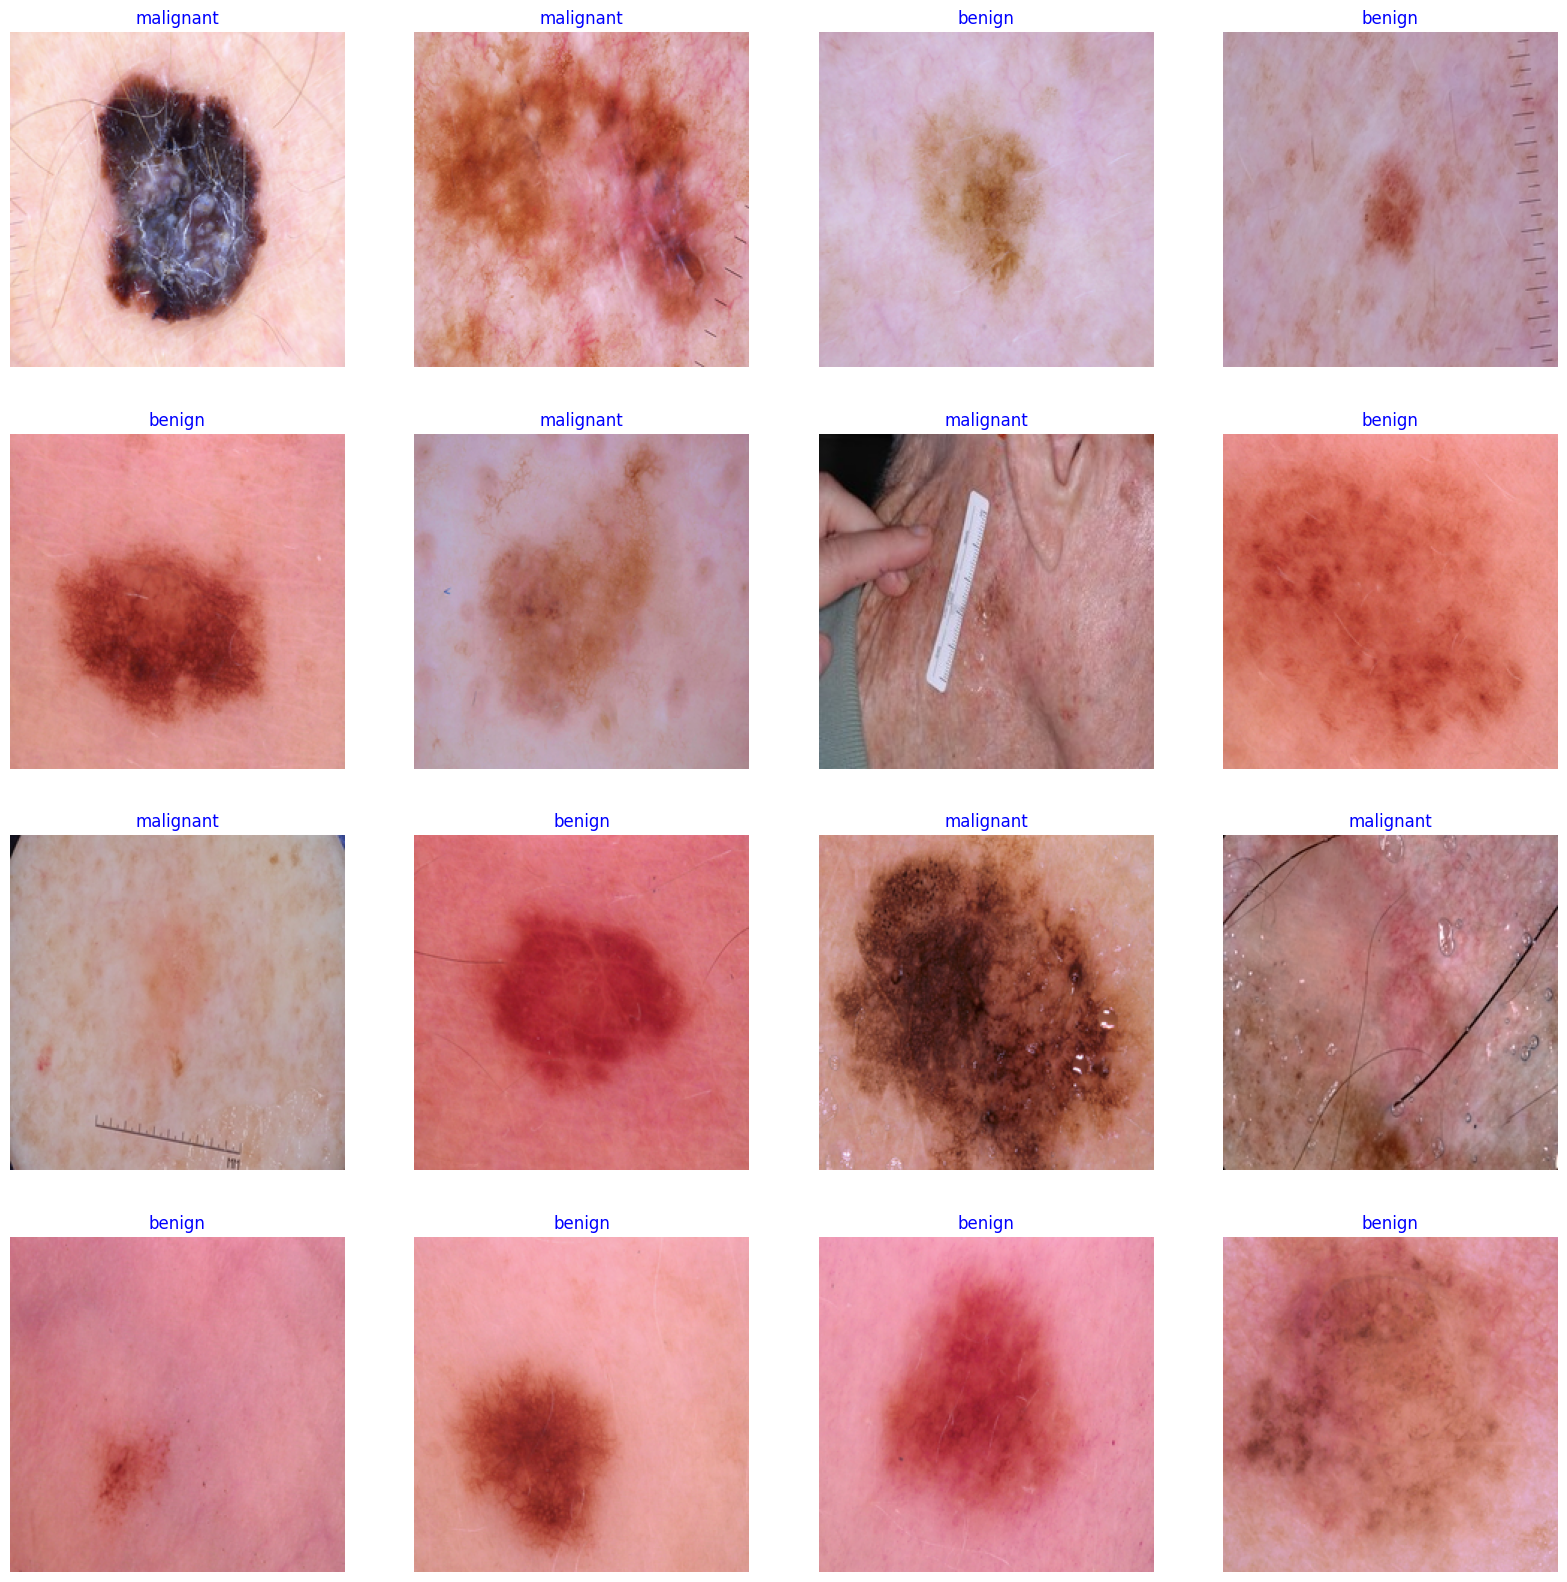

In [33]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()


In [34]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-t

In [36]:
epochs = 50   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)


Epoch 1/50
165/165 [==============================] - 128s 727ms/step - loss: 6.1129 - accuracy: 0.7990 - val_loss: 4.6897 - val_accuracy: 0.7909
Epoch 2/50
165/165 [==============================] - 117s 711ms/step - loss: 3.9194 - accuracy: 0.8658 - val_loss: 3.3461 - val_accuracy: 0.8364
Epoch 3/50
165/165 [==============================] - 115s 697ms/step - loss: 2.7873 - accuracy: 0.8999 - val_loss: 2.4651 - val_accuracy: 0.8788
Epoch 4/50
165/165 [==============================] - 118s 718ms/step - loss: 2.0557 - accuracy: 0.9219 - val_loss: 1.8749 - val_accuracy: 0.8485
Epoch 5/50
165/165 [==============================] - 115s 694ms/step - loss: 1.5438 - accuracy: 0.9344 - val_loss: 1.4385 - val_accuracy: 0.8848
Epoch 6/50
165/165 [==============================] - 114s 692ms/step - loss: 1.1521 - accuracy: 0.9560 - val_loss: 1.1452 - val_accuracy: 0.8924
Epoch 7/50
165/165 [==============================] - 114s 693ms/step - loss: 0.8848 - accuracy: 0.9575 - val_loss: 0.9801 -

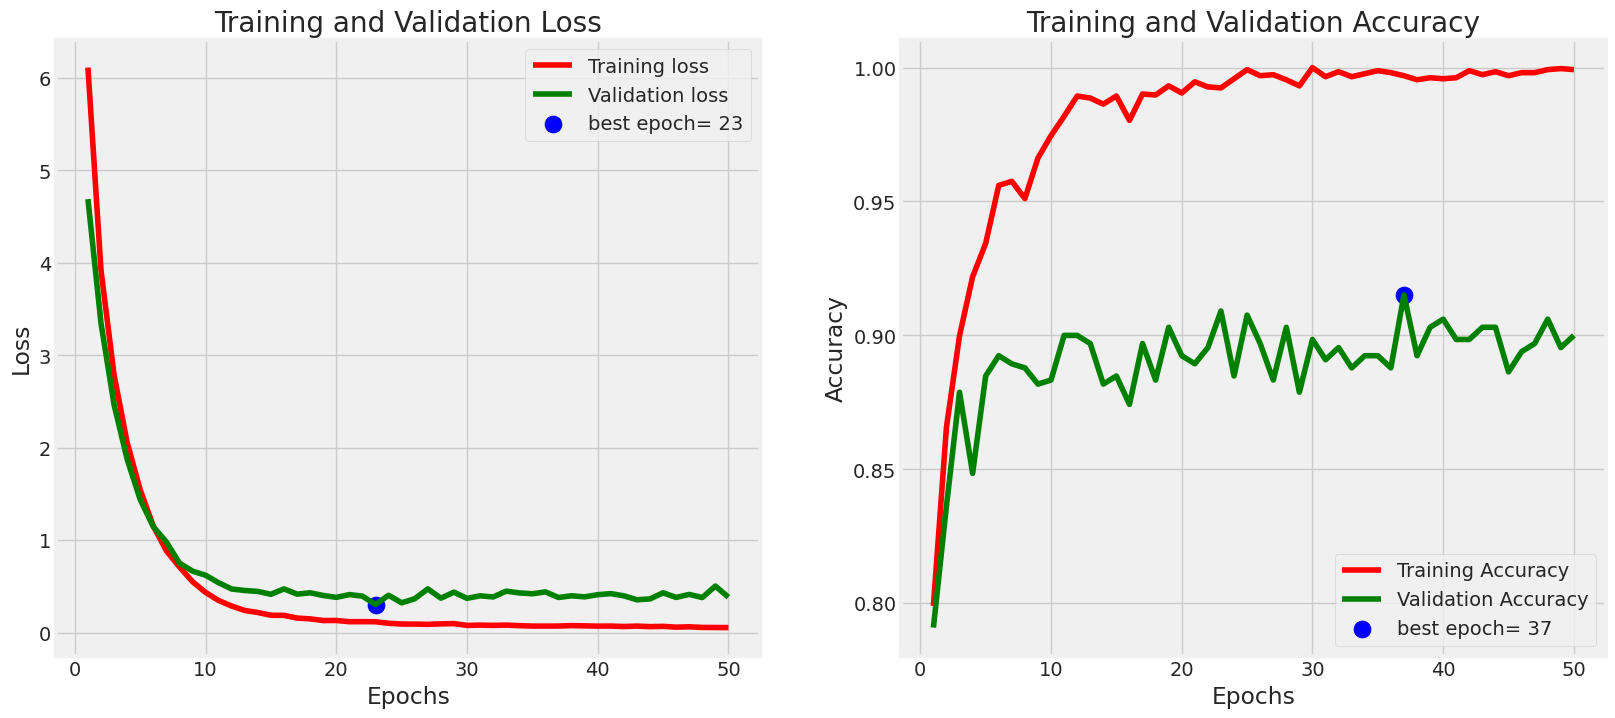

In [37]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [38]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 1s 135ms/step - loss: 0.5009 - accuracy: 0.8500
Train Loss:  0.04735409468412399
Train Accuracy:  1.0
--------------------
Test Loss:  0.500857412815094
Test Accuracy:  0.8500000238418579


In [39]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

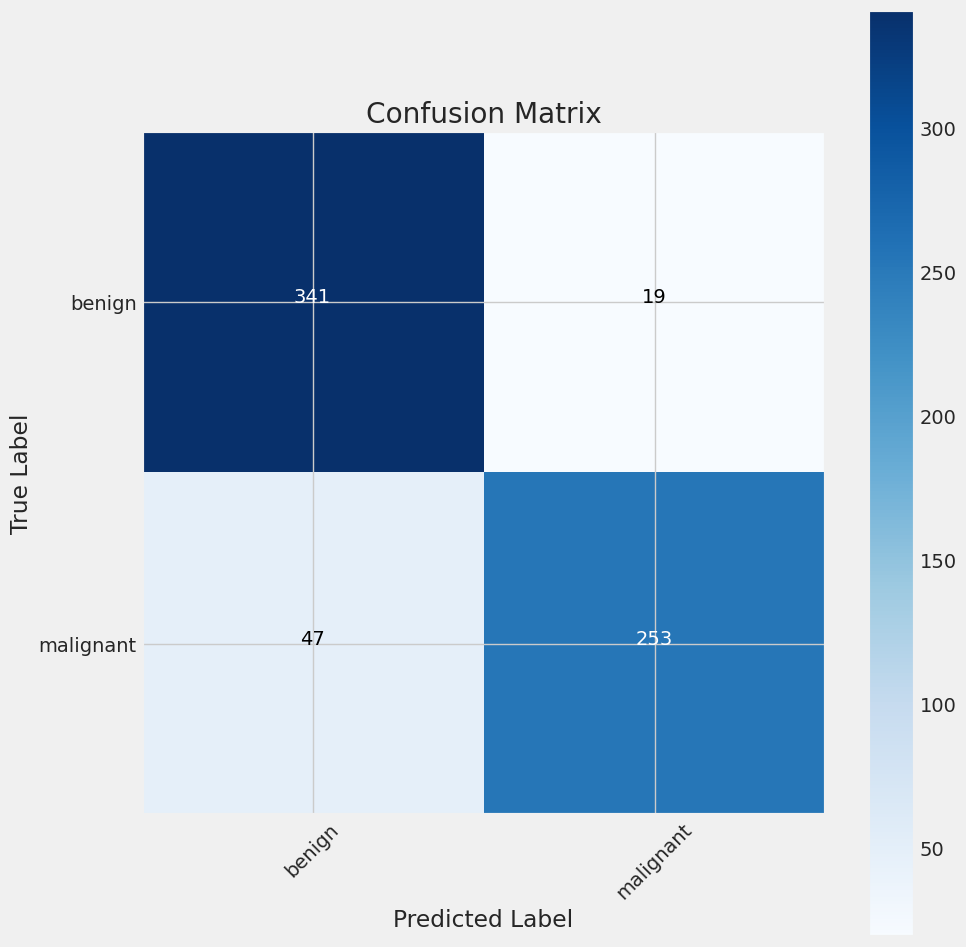

In [40]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [41]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.88      0.95      0.91       360
   malignant       0.93      0.84      0.88       300

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660



In [42]:
#Save the model
model.save('Skin Cancer.h5')

In [49]:
loaded_model = tf.keras.models.load_model('/content/Skin Cancer.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [51]:
image_path = 'img.jpg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Benign', 'Malignant']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/img.jpg'

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

print("model converted")

# Save the model.
with open('Brain.tflite', 'wb') as f:
    f.write(tflite_model)

model converted
